# LSTM Stock Price Prediction Model

This notebook implements an LSTM model for stock price prediction that will be used in the Flask application. The model includes:
- Data preprocessing and visualization
- LSTM model architecture matching the Flask app requirements
- Model training and evaluation
- Model saving for Flask deployment

## Setup and Dependencies

In [2]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Data Collection and Preprocessing

In [3]:
def fetch_stock_data(symbol, start_date='2005-01-01'):
    """Fetch stock data from Yahoo Finance."""
    end_date = date.today().strftime('%Y-%m-%d')
    df = yf.download(symbol, start_date, end_date)
    return df

# Fetch data for demonstration (using SBIN.NS as example)
df = fetch_stock_data('SBIN.NS')
# Check if data is fetched correctly
print(f"Data shape: {df.shape}")
df.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data shape: (5072, 5)


Price,Close,High,Low,Open,Volume
Ticker,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS
Date,,,,,
2005-01-03,47.114105,47.627816,46.708163,47.024296,22590407
2005-01-04,46.693794,47.340422,46.424365,47.336831,26206416
2005-01-05,44.362343,47.117700,42.461972,46.697393,52142335
2005-01-06,43.417545,45.184997,42.831986,44.204276,47719200
2005-01-07,44.233013,44.541957,43.485797,43.783967,30985674


In [4]:
df.tail()

Price,Close,High,Low,Open,Volume
Ticker,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS,SBIN.NS
Date,,,,,
2025-07-15,816.450012,821.000000,810.500000,811.000000,9297645
2025-07-16,831.700012,834.200012,815.299988,816.000000,16458920
2025-07-17,829.000000,842.500000,826.349976,838.400024,23073718
2025-07-18,823.349976,832.650024,820.250000,832.000000,15387801
2025-07-21,824.200012,827.349976,817.950012,823.000000,8852594


## Data Visualization

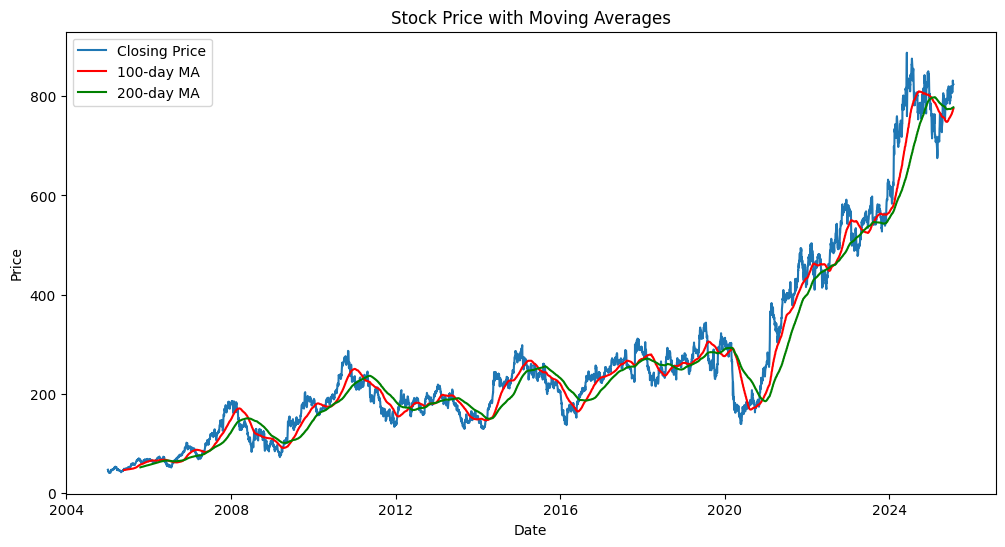

In [5]:
# Plot closing price with moving averages
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price')
plt.plot(df['Close'].rolling(100).mean(), 'r', label='100-day MA')
plt.plot(df['Close'].rolling(200).mean(), 'g', label='200-day MA')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Data Preparation

In [6]:
# Inspect column names
print(df.columns)

# Prepare data for LSTM model
df_processed = df.reset_index()
# Drop columns safely
df_processed = df_processed.drop(['Date', 'Adj Close'], axis=1, errors='ignore')

# Split into training and testing sets
training_size = int(len(df_processed) * 0.70)
data_training = pd.DataFrame(df_processed['Close'][0:training_size])
data_testing = pd.DataFrame(df_processed['Close'][training_size:])

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = scaler.fit_transform(data_training)

# Create sequences for training
x_train = []
y_train = []
for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100:i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
print(f"Training data shape: {x_train.shape}")


MultiIndex([( 'Close', 'SBIN.NS'),
            (  'High', 'SBIN.NS'),
            (   'Low', 'SBIN.NS'),
            (  'Open', 'SBIN.NS'),
            ('Volume', 'SBIN.NS')],
           names=['Price', 'Ticker'])
Training data shape: (3450, 100, 1)


C:\Users\kumar\AppData\Local\Temp\ipykernel_2864\2985100205.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_processed = df_processed.drop(['Date', 'Adj Close'], axis=1, errors='ignore')


## LSTM Model Architecture

In [8]:
# Create LSTM model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(100, 1)),
    Dropout(0.2),
    LSTM(60, activation='relu', return_sequences=True),
    Dropout(0.3),
    LSTM(80, activation='relu', return_sequences=True),
    Dropout(0.4),
    LSTM(120, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [9]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - loss: 0.0669 - val_loss: 0.0038
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0108 - val_loss: 0.0035
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 0.0092 - val_loss: 0.0066
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0083 - val_loss: 0.0035
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - loss: 0.0072 - val_loss: 0.0025
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0066 - val_loss: 0.0028
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - loss: 0.0057 - val_loss: 0.0111
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s 128ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 13s

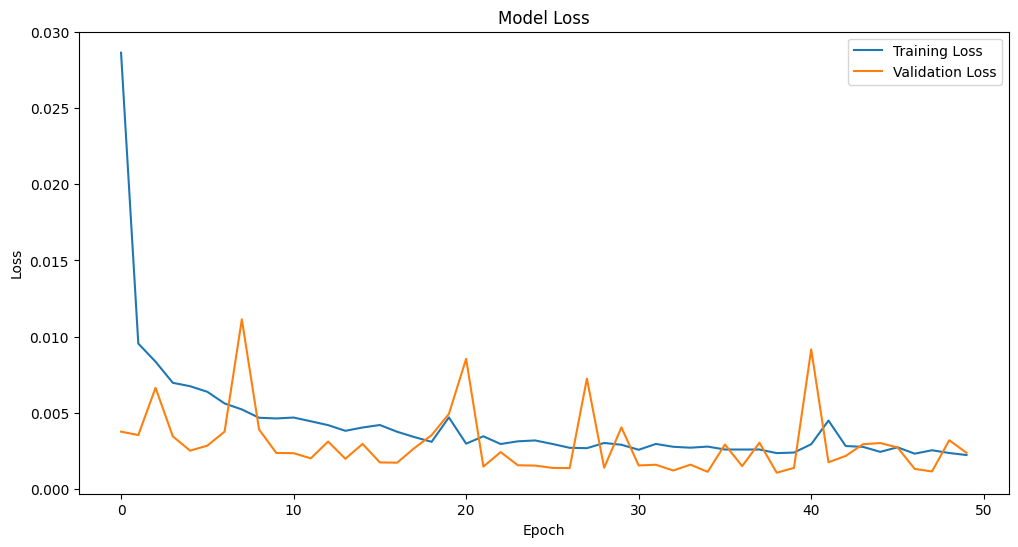

In [10]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model Evaluation

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


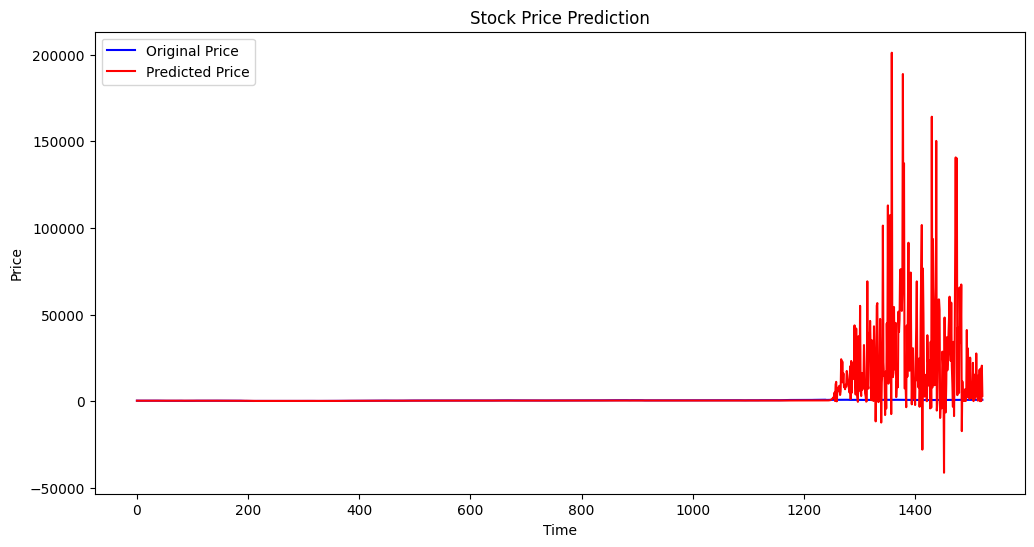

In [13]:
# Prepare test data
past_100_days = data_training.tail(100)
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)
input_data = scaler.transform(final_df)

x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100:i])
    y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

# Make predictions
y_predicted = model.predict(x_test)

# Scale back to original
scale_factor = 1/scaler.scale_[0]
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test, 'b', label='Original Price')
plt.plot(y_predicted, 'r', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Save Model for Flask Application

In [12]:
# Save the model
model.save('keras_model.h5')
print("Model saved successfully as 'keras_model.h5'")

Model saved successfully as 'keras_model.h5'
